# Basic stats of RPD data

In [1]:
datafile = 'RPD__Part_I_Crime_2011_to_Present.csv'

#-----------------
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:,.3f}'.format
from IPython.display import display
import matplotlib.pyplot as plt

print('...loading data')
if 'pkl' in datafile:
    df = pd.read_pickle(datafile)
else:
    df = pd.read_csv(datafile, skipinitialspace=True) 

ts = df['OccurredFrom_Timestamp'].values
dates = [t[0:10] for t in ts]
df['OccurredFrom_Timestamp'] = pd.to_datetime(df['OccurredFrom_Timestamp'])
df['OccurredFrom_Date_Day'] = df['OccurredFrom_Timestamp'].dt.dayofweek
df['analog_date'] = pd.to_timedelta(df['OccurredFrom_Timestamp']).dt.total_seconds()

print('n:',df.shape[0])
print('cols:',df.shape[1])

print('\ncolumns: ')
for c in df.columns:
    print(c,end=',')

...loading data
n: 78312
cols: 42

columns: 
X,Y,OBJECTID,Geocode_Address,Geocode_Street,Case_Number,OccurredFrom_Date_Year,OccurredFrom_Date_Month,OccurredFrom_Time,OccurredFrom_Timestamp,OccurredThrough_Date_Year,OccurredThrough_Date_Month,OccurredThrough_Time,OccurredThrough_Timestamp,Reported_Date_Year,Reported_Date_Month,Reported_Time,Reported_Timestamp,Address_StreetFull,Address_City,Address_State,Patrol_Beat,Patrol_Section,Case_Status,Statute_Title,Statute_Section,Statute_Subsection,Statute_Degree,Statute_Class,Statute_Category,Statute_Text,Statute_Description,Statute_CrimeCategory,Statute_Attempted,Weapon_Description,Larceny_Type,Location_Type,Geo_Beat,Geo_Section,Geo_Section_Num,OccurredFrom_Date_Day,analog_date,

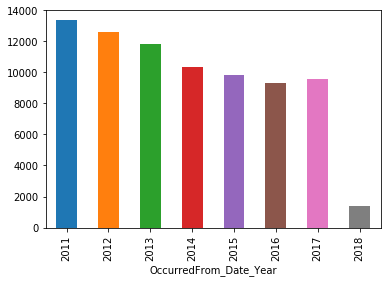

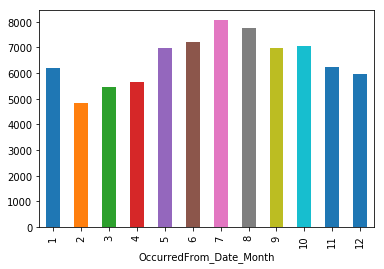

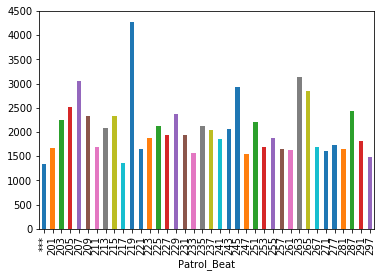

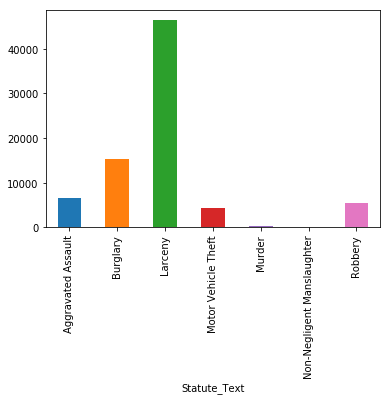

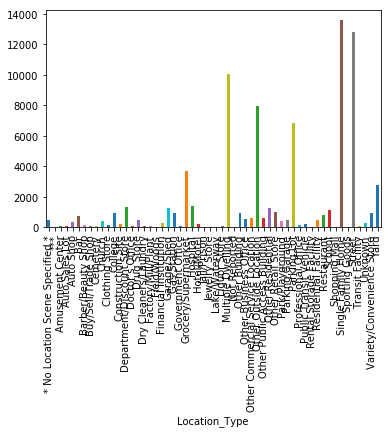

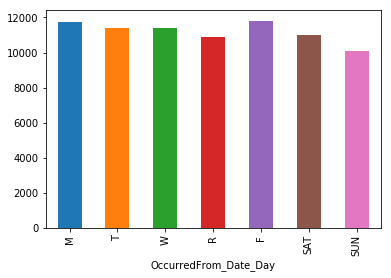

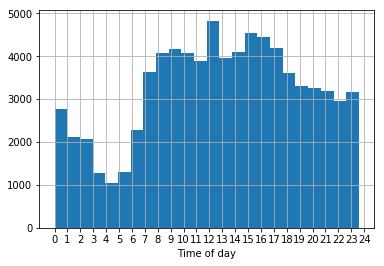

In [2]:
# simple plots 

key_fields = ['OccurredFrom_Date_Year','OccurredFrom_Date_Month',
              'Patrol_Beat','Statute_Text','Location_Type']

def group_bar(categorical_col):
    """ barplot of counts partitioned by categorical_col """
    g = df.groupby(categorical_col)
    g.size().plot.bar()
    plt.show()

[group_bar(field) for field in key_fields]

#day of week needs special formating
g = df.groupby('OccurredFrom_Date_Day')
g.size().plot.bar()
plt.xticks(list(range(7)), ['M','T','W','R','F','SAT','SUN'])
plt.show()

#time of day needs to be done as a hist
times = df['OccurredThrough_Time']/100

times.hist(bins=24)
plt.xticks(range(25))
plt.xlabel('Time of day')
plt.show()


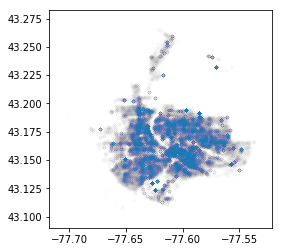

In [3]:
#2D density plot
plt.figure(figsize=(4,4))
plt.scatter(df['X'], df['Y'],alpha=0.005,s=10)
plt.show()

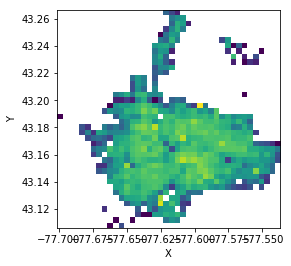

In [4]:
# heatmap
from matplotlib.colors import LogNorm
from itertools import combinations

good_features = ['X','Y']

feature_combo_list = list(combinations(good_features,2))        
for feature_subset in feature_combo_list:
    plt.figure(figsize=(4,4))
    df_clean = df[list(feature_subset)].dropna()
    h = plt.hist2d(df_clean.loc[:,feature_subset[0]], df_clean.loc[:,feature_subset[1]], bins=40, norm=LogNorm())
    #plt.hist2d(df.loc[:,feature_subset[0]], df.loc[:,feature_subset[1]], bins=40)
    plt.xlabel(feature_subset[0])
    plt.ylabel(feature_subset[1])
    #plt.colorbar()
    plt.show()

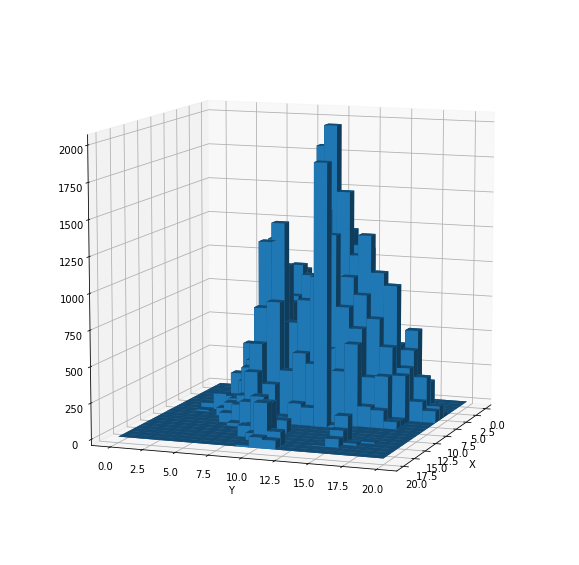

In [5]:
# 3D view
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  


f1 = 'X'
f2 = 'Y'
counts, xedges, yedges, Image = plt.hist2d(df_clean.loc[:,f1], df_clean.loc[:,f2], bins=20, norm=LogNorm())
plt.close()
data_array = counts
#
# Create a figure for plotting the data as a 3D histogram.
#
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
#
# Create an X-Y mesh of the same dimension as the 2D data. You can
# think of this as the floor of the plot.
#
x_data, y_data = np.meshgrid( np.arange(data_array.shape[1]),
                              np.arange(data_array.shape[0]) )
#
# Flatten out the arrays so that they may be passed to "ax.bar3d".
# Basically, ax.bar3d expects three one-dimensional arrays:
# x_data, y_data, z_data. The following call boils down to picking
# one entry from each array and plotting a bar to from
# (x_data[i], y_data[i], 0) to (x_data[i], y_data[i], z_data[i]).
#
x_data = x_data.flatten()
y_data = y_data.flatten()
z_data = data_array.flatten()


ax.bar3d( x_data,
          y_data,
          np.zeros(len(z_data)),
          1, 1, z_data )
#ax.view_init(elev=40., azim=-10)
ax.view_init(elev=10., azim=20)
ax.set_xlabel(f1)
ax.set_ylabel(f2)
#plt.savefig('3dhist.png')
#for ii in range(0,360,1):
#    ax.view_init(elev=10., azim=ii)
#    plt.savefig("movie%d.png" % ii)
#
# Finally, display the plot.
#
plt.show()

## Correlations

The approach here will be to bin data by time. Then calculate the counts of each crime type per bin. Then calculated the correlation between each crime type.

In [6]:
crime_types = df['Statute_Text'].unique()
display(crime_types)

#df[['months_from_start', 'Statute_Text']]

array(['Larceny', 'Aggravated Assault', 'Burglary', 'Motor Vehicle Theft',
       'Robbery', 'Murder', 'Non-Negligent Manslaughter'], dtype=object)

Larceny
Aggravated Assault
Burglary
Motor Vehicle Theft
Robbery
Murder
Non-Negligent Manslaughter


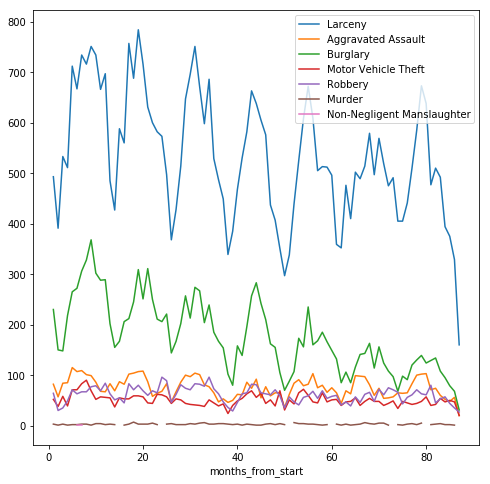

In [7]:
df['months_from_start'] = 12 * (df['OccurredFrom_Date_Year'] - 2011) + df['OccurredFrom_Date_Month']
counts = pd.DataFrame()
for crime in crime_types:
    print(crime)
    g = df[df['Statute_Text'] == crime].groupby(('months_from_start'))
    counts[crime] = g.size()
#display(counts)
#counts['Larceny'].plot()
counts.plot(figsize=(8,8))

In [8]:
# this will only work for numerical data
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).reset_index()
    au_corr.columns = ['0','1','r']
    au_corr['abs(r)'] = au_corr['r'].abs()
    au_corr.sort_values(by='abs(r)',ascending=False, inplace=True)
    return au_corr[0:n]
#============================================================
print("Top Correlations")
display(get_top_abs_correlations(counts, 15))

Top Correlations


,0,1,r,abs(r)
1,Larceny,Burglary,0.834,0.834
0,Larceny,Aggravated Assault,0.773,0.773
3,Larceny,Robbery,0.670,0.670
12,Burglary,Robbery,0.619,0.619
6,Aggravated Assault,Burglary,0.605,0.605
2,Larceny,Motor Vehicle Theft,0.538,0.538
11,Burglary,Motor Vehicle Theft,0.533,0.533
7,Aggravated Assault,Motor Vehicle Theft,0.480,0.480
8,Aggravated Assault,Robbery,0.469,0.469
20,Murder,Non-Negligent Manslaughter,-0.437,0.437


## Clustering
first with k-means
then with Gaussian mixture model


In [9]:
# find best k

from sklearn import cluster
from sklearn import mixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabaz_score
from sklearn.model_selection import train_test_split
import os, csv

def calc_sil_score(X,y):
    """ Calculate silhoutte score with efficiency mods.
    """
    if(X.shape[0] > 5000):
        # due to efficiency reasons, we need to only use subsample
        sil_score_list = []
        for i in range (0,10):
            X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                 test_size=2000./X.shape[0])        
            sil_score = silhouette_score(X_test,y_test)
            sil_score_list.append(sil_score)
        sil_score_avg = np.nanmean(sil_score_list)
    else:   
        sil_score_avg = silhouette_score(X,y)

    return sil_score_avg

X_dirty = np.vstack((df['X'].values, df['Y'].values)).T
print(X_dirty.shape)
X = X_dirty[~np.isnan(X_dirty).any(axis=1)]
print(X.shape)

cluster_list = []
sil_scores = []
ch_scores = []
for k in range(2,15):
    print('\nk=' + str(k) )

    png_fname = 'output/clusters_' + '_' + str(k) + '.png'
    cluster_fname = 'output/face_clusters_' + str(k) + '.csv'
    if os.path.isfile(png_fname):
        logging.info('file exists, skipping...' + png_fname)
        continue
    k_means = cluster.KMeans(n_clusters=k, max_iter=1000, n_jobs=-1)
    k_means.fit(X)
    y = k_means.predict(X)

    sil_score = calc_sil_score(X,y)
    ch_score = calinski_harabaz_score(X,y)

    print('silhouette score with ' + str(k) + ' clusters: ' + \
                     '{0:.3f}'.format(sil_score))
    print('CH score with ' + str(k) + ' clusters: ' + \
                     '{0:.3f}'.format(ch_score))

    clusters = k_means.cluster_centers_

    # write the clusters to a csv file
    with open(cluster_fname, 'w') as f:
        feature_data = []
        writer = csv.writer(f)
        writer.writerow(['X', 'Y'])
        for cluster_i in clusters:
            row_txt = [str(x) for x in list(cluster_i)]
            writer.writerow(row_txt)
            
    cluster_list.append(clusters)
    #sil_scores.append(sil_score)
    ch_scores.append(ch_score)

(78312, 2)
(77855, 2)

k=2
silhouette score with 2 clusters: 0.389
CH score with 2 clusters: 54242.802

k=3
silhouette score with 3 clusters: 0.385
CH score with 3 clusters: 59380.528

k=4
silhouette score with 4 clusters: 0.365
CH score with 4 clusters: 55657.972

k=5
silhouette score with 5 clusters: 0.372
CH score with 5 clusters: 59423.117

k=6
silhouette score with 6 clusters: 0.410
CH score with 6 clusters: 69190.122

k=7
silhouette score with 7 clusters: 0.395
CH score with 7 clusters: 70543.674

k=8
silhouette score with 8 clusters: 0.384
CH score with 8 clusters: 69569.375

k=9
silhouette score with 9 clusters: 0.383
CH score with 9 clusters: 69158.342

k=10
silhouette score with 10 clusters: 0.364
CH score with 10 clusters: 69581.673

k=11
silhouette score with 11 clusters: 0.361
CH score with 11 clusters: 69564.669

k=12


KeyboardInterrupt: 

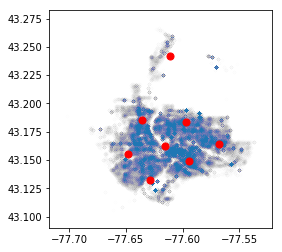

In [10]:
# best k?
k = 6
plt.figure(figsize=(4,4))
plt.scatter(df['X'], df['Y'],alpha=0.005,s=10)
plt.scatter(cluster_list[k][:,0],cluster_list[k][:,1] ,c='red',s=50)
plt.show()

In [12]:
# GaussianMixture model, using k from above, we could do BIC k selection
# this is kinda slow
import itertools
gmm = mixture.GaussianMixture(n_components=k,
                              covariance_type='full',
                              #tol=1e-8,
                              tol=1e-6,
                              max_iter=1000,
                              #max_iter=200,
                              n_init=3,
                              reg_covar=2e-6)            
gmm.fit(X)
bic = gmm.bic(X)  

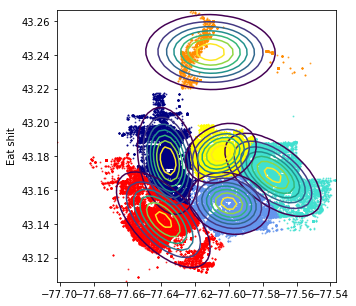

In [13]:
from scipy import linalg
from scipy.stats import multivariate_normal

# plot GMM result
Y = gmm.predict(X)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                                      'darkorange', 'red', 'yellow'])
plt.figure(figsize=(5,5))
for i, (mean, cov, color) in enumerate(zip(gmm.means_, gmm.covariances_,
                                           color_iter)):
    plt.ylabel('Eat shit')
    v, w = linalg.eigh(cov)
    if not np.any(Y == i):
        continue
    plt.scatter(X[Y == i, 0], X[Y == i, 1], .8, color=color,alpha=.7)

    x_vals = np.linspace(X[:,0].min(), X[:,0].max(), 50)
    y_vals = np.linspace(X[:,1].min(), X[:,1].max(), 50)
    x, y = np.meshgrid(x_vals, y_vals)    
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    rv = multivariate_normal(mean, cov)

    try: # not sure why, was running into ValueErrors
        plt.contour(x, y, rv.pdf(pos))
    except ValueError:
        pass

plt.axis('equal')
plt.show()